In [301]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

from petro_utils import compare_pred_results

import seaborn as sns

# Predicting Production with Machine Learning
The core of Petro.ai's machine learning pipeline are multivariate models that predict production based on geologic and engineering features of wells from a region of interest.  This notebook walks through a simplified workflow for building one of these models.  Your task is to run the simplified model, and understand the steps and the generated results.  You can use this as a start to improve the model, and demonstrate your experience and data science skills.

If need any clarification or have questions, feel free to reach out to Brendon at <brendon.hall@petro.ai>.

## Data
Petro.ai provides a download of well stats.  These are properties and attributes of the wells in the database.  These can be used as features to train predictive models. Well Stats contains one row per well with 100+ columns.  Don't worry, we won't use them all!

Here is a brief description of some of the columns in well stats that we might consider for modeling.
 * `totalDrainage` - predicted drainage area for a well (using Petro.ai drainage model)
 * `prodOil12mo` - cumulative 12 month oil production
 * `avgHzDistAnyZone` - average distance to nearby wells
 * `latitude`, `longitude` - surface location of well head
 * `angleFromSHMax` - angle between well azimuth and maximum horizontal stress direction


Well stats contains a raw download of all the wells in the collection.  There might be missing data, and we can transform these features before training a model.

As a first step, let's read the file `data/part2/well_stats_delaware.csv` into a pandas dataframe.

In [302]:
# read the well stats data, save to a pandas dataframe
df = pd.read_csv('../data/part2/well_stats.csv') # answer

# print the number of rows and columns in this dataframe.
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the raw well stats file.")

There are 2457 rows and 172 columns in the raw well stats file.


Let's rename the `totalDrainage` column to `drainage_area` to be more clear.

In [303]:
# rename the 'totalDrainage' column to 'drainage_area'
df.rename(columns={'totalDrainage':'drainage_area'}, inplace=True)

In [304]:
df.columns

Index(['wellID', 'wellAPI', 'interval', 'lateralLength', 'perfLength',
       'completionYear', 'totalProppant', 'totalFluidPumped', 'orientation',
       'tvd',
       ...
       'attributes_NTG_WFMP_upper', 'attributes_NTG_WFMP_lower',
       'attributes_NTG_WFMPB_upper', 'attributes_NTG_WFMPB_lower',
       'attributes_PHIT_WFMPC', 'attributes_PHIT_WFMPB_upper',
       'attributes_PHIT_WFMP_upper', 'attributes_PHIT_WFMP_lower',
       'attributes_PHIT_TBSG4', 'attributes_PHIT_WFMPB_lower'],
      dtype='object', length=172)

## Data Exploration
For an initial model we'll start with a few features from well stats described above:

- drainage area
- totalProppantByPerfLength
- avgHzDistAnyZone
- latitude
- longitude
- angleFromSHMax

There are many more we can try, but this will get us started.  For the first model,
let's try and predict 12 month cumulative oil production `prodOil12mo` directly.

First, plot the distribution of these features with respect to the `prodOil12mo` target.

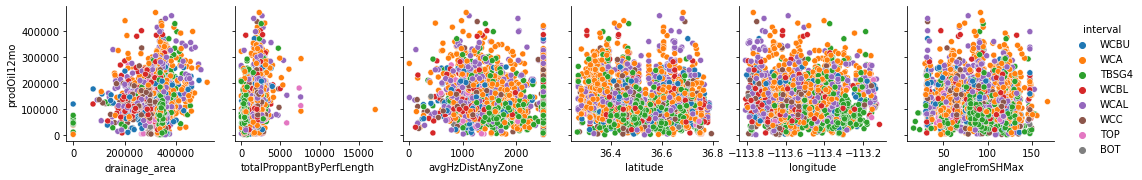

In [305]:
feature_names = ['drainage_area', 'totalProppantByPerfLength', 'avgHzDistAnyZone', 'latitude', 'longitude', 'angleFromSHMax']

target = 'prodOil12mo'

g = sns.pairplot(df, x_vars=feature_names, y_vars=target, hue='interval')
plt.show()

Did you notice any significant trends in these features?  Any outliers or potential issues? There are a number of wells with zero drainage, we'll filter those out.

Feel free to experiment with other types of plots, features, etc.

**[Debug Question]** In the next cell, we want to find the 12 mo. cumulative oil production for a specific well with `wellAPI` = 4200000036.  There is a bug in this code though.  Can you fix it to output the correct production amount?

In [306]:
df_model = df[['drainage_area', 'totalProppantByPerfLength', 'avgHzDistAnyZone', 'latitude', 'longitude', 'angleFromSHMax', 'lateralLength', 'prodOil12mo']]
df_model.isna().sum()

drainage_area                  0
totalProppantByPerfLength    525
avgHzDistAnyZone               0
latitude                       0
longitude                      0
angleFromSHMax                 0
lateralLength                  6
prodOil12mo                  154
dtype: int64

In [307]:
print(df_model.shape)
df_model

(2457, 8)


,drainage_area,totalProppantByPerfLength,avgHzDistAnyZone,latitude,longitude,angleFromSHMax,lateralLength,prodOil12mo
0,194838.58,2054.4040,1230.63430,36.389086,-113.386406,119,9247.0,132413.0000
1,344069.84,NaN,1350.47670,36.390055,-113.292040,121,9326.0,334629.0000
2,346702.40,1445.6741,2500.00000,36.371887,-113.457380,118,9163.0,185974.0000
3,343703.38,NaN,2500.00000,36.765614,-113.568970,133,NaN,18689.0000
4,346629.38,2625.1914,1311.51060,36.378030,-113.521040,59,6713.0,NaN
...,...,...,...,...,...,...,...,...
2452,0.00,NaN,2500.00000,36.599530,-113.329620,131,3433.0,46537.2700
2453,343003.80,NaN,1850.67350,36.436480,-113.250910,90,2168.0,104259.6950
2454,288406.78,2002.8323,936.39014,36.450010,-113.243910,91,9540.0,99119.4100
2455,346098.22,NaN,2496.40060,36.629090,-113.323060,55,NaN,7870.9844


## Data Filtering

Remove any wells with zero drainage_area from the dataset.

In [308]:
# Remove wells with zero drainage area
df_model = df_model[df_model['drainage_area'] > 0].copy()
df_model.shape

(2445, 8)

In [309]:
print(df_model.shape)

(2445, 8)


Now remove any wells that are missing data for any of the features or target from the dataset.  How many wells are left in the dataset?

In [310]:
# Remove wells missing features or production
df_model = df_model.dropna(inplace=False)
print(f"There are {df_model.shape[0]} rows in the cleaned well stats file.")

There are 1798 rows in the cleaned well stats file.


In [311]:
#print(f"There are {df_model.shape[0]} rows in the cleaned well stats file.")
df_model.drop(['latitude','longitude'], axis = 1, inplace=True)

In [312]:
print(df_model.columns)

Index(['drainage_area', 'totalProppantByPerfLength', 'avgHzDistAnyZone',
       'angleFromSHMax', 'lateralLength', 'prodOil12mo'],
      dtype='object')


# Transforming the Data

In [313]:
from sklearn import preprocessing
scaler=preprocessing.MinMaxScaler(feature_range=(0,1))
scaler.fit(df_model)
df_scaled=scaler.transform(df_model)
print(df_scaled.shape)
print(df_scaled)

(1798, 6)
[[0.2798574  0.1200581  0.49114602 0.67763158 0.60121525 0.27952586]
 [0.64144167 0.0844839  1.         0.67105263 0.59422341 0.39381615]
 [0.64174772 0.02677062 1.         0.72368421 0.16847012 0.20840304]
 ...
 [0.63977151 0.15079268 0.38393893 0.44078947 0.63967038 0.43843496]
 [0.65660151 0.14675609 1.         0.44078947 0.6084568  0.35105256]
 [0.50264113 0.11704425 0.37319159 0.49342105 0.62560346 0.20848287]]


In [314]:
df_scaled = pd.DataFrame(df_scaled,columns=['drainage_area', 'totalProppantByPerfLength', 'avgHzDistAnyZone',
       'angleFromSHMax', 'lateralLength', 'prodOil12mo'])


In [315]:
scaled_features = ['drainage_area', 'totalProppantByPerfLength', 'avgHzDistAnyZone','angleFromSHMax', 'lateralLength']
scaled_target = ['prodOil12mo']
x_scaled = df_scaled.drop(['prodOil12mo'], axis = 1)
y_scaled = df_scaled[scaled_target]

In [316]:
x_scaled

,drainage_area,totalProppantByPerfLength,avgHzDistAnyZone,angleFromSHMax,lateralLength
0,0.279857,0.120058,0.491146,0.677632,0.601215
1,0.641442,0.084484,1.000000,0.671053,0.594223
2,0.641748,0.026771,1.000000,0.723684,0.168470
3,0.631755,0.165416,0.587503,0.618421,0.521142
4,0.630513,0.036391,1.000000,0.223684,0.108207
...,...,...,...,...,...
1793,0.621553,0.089642,0.681571,0.526316,0.149076
1794,0.580148,0.145659,0.455924,0.546053,0.610454
1795,0.639772,0.150793,0.383939,0.440789,0.639670
1796,0.656602,0.146756,1.000000,0.440789,0.608457


In [317]:
y_scaled

,prodOil12mo
0,0.279526
1,0.393816
2,0.208403
3,0.484728
4,0.081758
...,...
1793,0.507767
1794,0.646137
1795,0.438435
1796,0.351053


## Prepare Training Data

Now the dataset is ready to train a model.  Extract the features, $X$, and the "target" to be predicted, $y$, from the dataframe.  For now, we'll randomly select a third of the wells and set them aside to test the accuracy of the model.  We'll use the remainder as training data.

In [318]:
from sklearn.model_selection import train_test_split
#seed=99
#np.random.seed(seed)
#x_scaled = df_scaled.drop(['prodOil12mo'], axis = 1)
#y_scaled = df_scaled[scaled_target]

X_train, X_test, y_train, y_test = train_test_split(
    x_scaled, y_scaled, test_size=0.33, random_state=42)

## Train Random Linear Regression

Let's start simple. We'll build a simple random forest model and take a look at the prediction accuracy. 

In [319]:
from sklearn.linear_model import LinearRegression
#np.random.seed(seed)
lm=LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

## Model Evaluation
What is the $R^2$ score of this regression?  What is the error (or accuracy) of the result?

In [320]:
print(lm.intercept_)

[-0.13528279]


In [321]:
X_train

,drainage_area,totalProppantByPerfLength,avgHzDistAnyZone,angleFromSHMax,lateralLength
428,0.618956,0.085563,0.593819,0.092105,0.621442
1358,0.639342,0.026073,0.767057,0.322368,0.144831
1185,0.521062,0.153925,0.696414,0.223684,0.210671
31,0.664150,0.151568,0.422580,0.513158,0.591227
1604,0.630356,0.143516,1.000000,0.756579,0.196188
...,...,...,...,...,...
1130,0.602781,0.090567,0.425330,0.697368,0.176378
1294,0.307154,0.029085,0.509780,0.302632,0.455718
860,0.512654,0.134908,0.455801,0.868421,0.627435
1459,0.689247,0.103471,0.830822,0.223684,0.612452


In [322]:
y_train

,prodOil12mo
428,0.239886
1358,0.281745
1185,0.125608
31,0.670338
1604,0.219047
...,...
1130,0.086324
1294,0.296985
860,0.446970
1459,0.482571


In [323]:
lm.coef_.transpose()

array([[0.28625499],
       [0.49843695],
       [0.02085596],
       [0.04731141],
       [0.45088164]])

In [324]:
coeff_df = pd.DataFrame(lm.coef_.transpose(),X_train.columns,
columns=['Coefficient'])
coeff_df

,Coefficient
drainage_area,0.286255
totalProppantByPerfLength,0.498437
avgHzDistAnyZone,0.020856
angleFromSHMax,0.047311
lateralLength,0.450882


In [325]:
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

In [326]:
from sklearn.metrics import r2_score
test_set_r2 = r2_score(y_test,y_pred)
print('Testing rˆ2:',round(test_set_r2,2))

Testing rˆ2: 0.32


In [327]:
y_test

,prodOil12mo
1278,0.249714
220,0.220690
1519,0.054983
438,0.213298
1271,0.003544
...,...
18,0.607396
423,0.372390
1204,0.466413
285,0.566345


In [328]:
y_test_pred.shape

(594, 1)

In [329]:
y_train

,prodOil12mo
428,0.239886
1358,0.281745
1185,0.125608
31,0.670338
1604,0.219047
...,...
1130,0.086324
1294,0.296985
860,0.446970
1459,0.482571


Text(0.5, 1.0, 'Actual Vs. Predicted, Testing Data Set (30% of the data)')

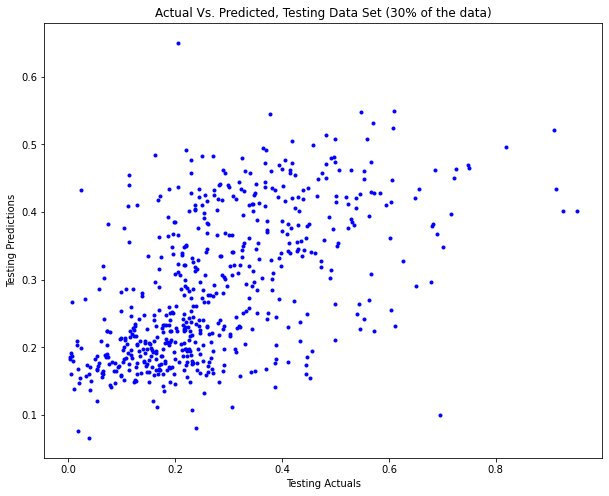

In [330]:
plt.figure(figsize = (10,8))
y_pred = lm.predict(X_test)
plt.plot(y_test ,y_pred , 'b.')
plt.xlabel('Testing Actuals')
plt.ylabel('Testing Predictions')
plt.title('Actual Vs. Predicted, Testing Data Set (30% of the data)')

Use the utility `compare_pred_results` function to plot the predicted vs. actual production.

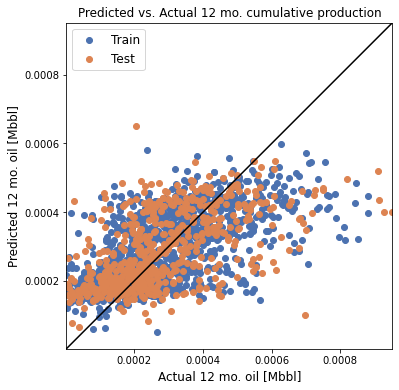

In [331]:
compare_pred_results(y_train, y_train_pred, y_test, y_test_pred, scale_factor=1e3, title="Predicted vs. Actual 12 mo. cumulative production",
                     xlabel="Actual 12 mo. oil [Mbbl]", ylabel="Predicted 12 mo. oil [Mbbl]")

The accuracy on the training data is significantly higher than the test data.  Random forest models are notorious for over-fitting. Do you notice any other interesting trends in these results?  There is plenty of room for improvement.  So far, we've guided you through building a simple model.  Now you can unleash your own skills and creativity to build a model that improves on these results.  Feel free to improve on the random forest model and/or use another library.  Be prepared to discuss your approach, what you tried, the pros/cons of your modeling approach, etc.

Some things you might try:
- hyperparameter tuning
- additional/different features from well stats
- feature selection/engineering
- proper cross-validation

You might also consider doing some error analysis.  Is the model making any big mistakes?  Is it due to bad training data or is there a systematic bias?  Can you explain why the model is making the decisions that it is?  Are some features more important than others in terms of making decisions?

Prepare a short presentation that demonstrates your data exploration, modeling and analysis efforts. Tell a story with the data. What are your insights on the problem/dataset?  Be prepared to answer questions on your approach and assumptions.  Think about how you would continue this work if you had more time and resources.  You'll give a brief presentation to a couple members of the Petro.ai team, and then we'll discussion around your experience with this task.